In [1]:
import numpy as np
import netCDF4 as nc
import scipy.signal as signal
import matplotlib.pyplot as plt
import pywt
from typing import Tuple, Optional

In [2]:
# Loading the NetCDF file
data_path = "29AP2022SHT1_r5_BAPBS_p.nc"
dataset = nc.Dataset(data_path, 'r')

In [3]:
# Exploring variables
print("Variables in the dataset:", dataset.variables.keys())

Variables in the dataset: dict_keys(['Headers', 'Procparams', 'SpecProcparams', 'RawI.R.1.C.1.B.1', 'RawQ.R.1.C.1.B.1', 'SpecPSD.R.1.C.1.B.1', 'TracePeak.R.1.C.1.B.1', 'TraceUSPeak.R.1.C.1.B.1', 'TraceSP.R.1.C.1.B.1', 'MMTMT.R.1.C.1.B.1', 'MMTMain.R.1.C.1.B.1', 'MMTEM.R.1.C.1.B.1', 'RawI.R.1.C.1.B.2', 'RawQ.R.1.C.1.B.2', 'SpecPSD.R.1.C.1.B.2', 'TracePeak.R.1.C.1.B.2', 'TraceUSPeak.R.1.C.1.B.2', 'TraceSP.R.1.C.1.B.2', 'MMTMT.R.1.C.1.B.2', 'MMTMain.R.1.C.1.B.2', 'MMTEM.R.1.C.1.B.2', 'RawI.R.1.C.1.B.3', 'RawQ.R.1.C.1.B.3', 'SpecPSD.R.1.C.1.B.3', 'TracePeak.R.1.C.1.B.3', 'TraceUSPeak.R.1.C.1.B.3', 'TraceSP.R.1.C.1.B.3', 'MMTMT.R.1.C.1.B.3', 'MMTMain.R.1.C.1.B.3', 'MMTEM.R.1.C.1.B.3', 'RawI.R.1.C.1.B.4', 'RawQ.R.1.C.1.B.4', 'SpecPSD.R.1.C.1.B.4', 'TracePeak.R.1.C.1.B.4', 'TraceUSPeak.R.1.C.1.B.4', 'TraceSP.R.1.C.1.B.4', 'MMTMT.R.1.C.1.B.4', 'MMTMain.R.1.C.1.B.4', 'MMTEM.R.1.C.1.B.4', 'RawI.R.1.C.1.B.5', 'RawQ.R.1.C.1.B.5', 'SpecPSD.R.1.C.1.B.5', 'TracePeak.R.1.C.1.B.5', 'TraceUSPeak.R.1.C.1

In [4]:
# Constants
RANGE_BINS = 180
CYCLES = 17
BEAMS = 5
NFFT = 256
INCI = 5

In [5]:
iq_data = np.zeros((CYCLES, BEAMS, INCI, RANGE_BINS, NFFT), dtype=complex)

# Extract and combine RawI and RawQ for each cycle and beam
for c in range(1, CYCLES + 1):
    for b in range(1, BEAMS + 1):
        # Variable names follow the pattern 'RawI.R.1.C.{c}.B.{b}' and 'RawQ.R.1.C.{c}.B.{b}'
        raw_i_key = f'RawI.R.1.C.{c}.B.{b}'
        raw_q_key = f'RawQ.R.1.C.{c}.B.{b}'
        
        if raw_i_key in dataset.variables and raw_q_key in dataset.variables:
            raw_i = dataset.variables[raw_i_key][:]
            raw_q = dataset.variables[raw_q_key][:]
            
            iq_data[c-1, b-1, :, :, :] = raw_i + 1j * raw_q
        else:
            print(f"Warning: Variables {raw_i_key} or {raw_q_key} not found.")

print("IQ Data Shape:", iq_data.shape)

dataset.close()

IQ Data Shape: (17, 5, 5, 180, 256)


In [ ]:
cycle_idx = 0
beam_idx = 0
iq_frames = iq_data[cycle_idx, beam_idx, :, :, :]

collated_data = np.zeros((RANGE_BINS, NFFT * INCI), dtype=complex)
for rb in range(RANGE_BINS):
    collated_data[rb, :] = np.concatenate([iq_frames[i, rb, :] for i in range(INCI)])

segments_per_bin = 12
segment_length = 512
segmented_data = np.zeros((RANGE_BINS, segments_per_bin, segment_length), dtype=complex)

for rb in range(RANGE_BINS):
    for seg in range(segments_per_bin):
        start = seg * (NFFT * INCI // segments_per_bin)
        end = start + segment_length
        segment = collated_data[rb, start:end]
        if len(segment) < segment_length:
            segment = np.pad(segment, (0, segment_length - len(segment)), mode='constant')
        segmented_data[rb, seg, :] = segment

# Apply Kaiser window to each segment
kaiser_window = signal.windows.kaiser(segment_length, beta=5.85)
segmented_data = segmented_data * kaiser_window[None, None, :]

print("Segmented Data Shape:", segmented_data.shape)

Segmented Data Shape: (180, 12, 512)


datawd_real min/max: -0.6449391114726534 2.511225211548076
datawd_imag min/max: -0.5275196591525189 3.6253650274105045
mu: 2.0 tau: 0.4 pseudos: 0.2169233760639239 sigma_d2: 0.08792364110997464
Level 4 - d_mag min/max: 0.000379482630932373 0.7514273072282864
Level 4 - delta_star min/max: 0.0005234255476121255 0.14898351759035436
Level 3 - d_mag min/max: 1.9415573010698148 3.694769422134482
Level 3 - delta_star min/max: 0.1999999866612177 0.19999999949819625


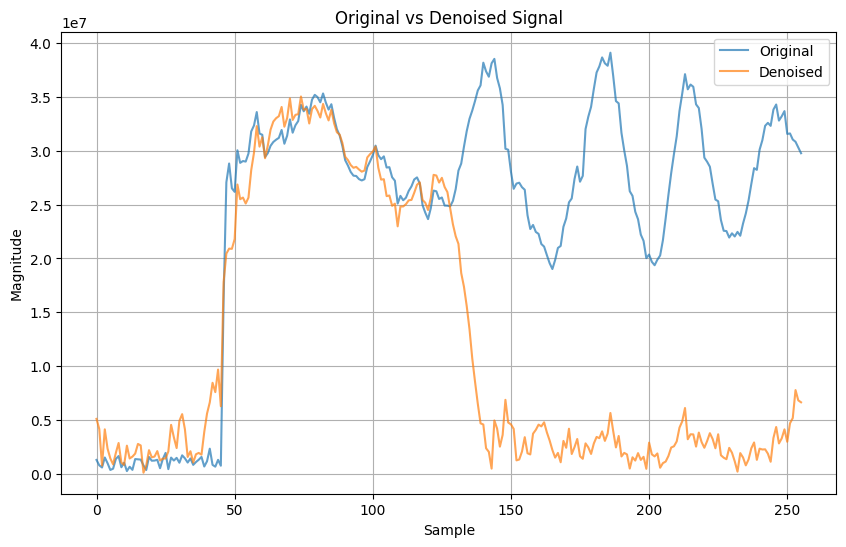

In [7]:
def mst_abs(
    signal: np.ndarray,
    wavelet: str = 'sym8',
    coarsest: int = 3,
    finestlev: int = 4,
    debug: bool = False
) -> np.ndarray:
    """
    Apply Adaptive-Bayesian Shrinkage to a complex signal using wavelet transforms.

    Args:
        signal: Complex input signal segment.
        wavelet: Wavelet type (default: 'sym8').
        coarsest: Coarsest decomposition level (default: 3).
        finestlev: Finest decomposition level (default: 4).
        debug: Enable debug printing (default: False).

    Returns:
        Denoised complex signal.
    """
    # Validate input
    if not np.iscomplexobj(signal):
        raise ValueError("Input signal must be complex.")

    # Separate real and imaginary parts
    real_part = signal.real
    imag_part = signal.imag

    # Forward Wavelet Transform
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)

    if debug:
        print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
        print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())

    # Compute prior parameters
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    pseudos = max(abs(Q1 - Q3) / 1.5, 1e-2)
    mu = min(1 / pseudos**2 if pseudos != 0 else 1e-1, 2.0)
    sigma_d2 = np.var(np.abs(signal))
    tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.4)

    if debug:
        print("mu:", mu, "tau:", tau, "pseudos:", pseudos, "sigma_d2:", sigma_d2)

    # Iterative shrinkage
    for i in range(finestlev, coarsest-1, -1):
        epsilon = min(1 - (1 / (i - coarsest + 1)), 0.3)
        slice_start, slice_end = 2**i, (2**(i+1) if i < finestlev else len(datawd_real))
        d_real = datawd_real[slice_start:slice_end]
        d_imag = datawd_imag[slice_start:slice_end]
        if len(d_real) == 0:
            continue

        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)
        m_star = epsilon * de + (1 - epsilon) * m

        # Vectorized shrinkage calculation
        num = tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))
        denom = (tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10
        delta_mag = np.clip(num / denom / mu, 0, 0.2)
        delta_star = np.clip(((1 - epsilon) * m * delta_mag) / (m_star + 1e-10), 0, 0.2)

        direction = d_real + 1j * d_imag
        direction_normalized = direction / (np.abs(direction) + 1e-10)
        datawd_real[slice_start:slice_end] = delta_star * direction_normalized.real
        datawd_imag[slice_start:slice_end] = delta_star * direction_normalized.imag

        if debug:
            print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
            print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())

    # Inverse Wavelet Transform
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    ysig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    ysig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    return (ysig_real + 1j * ysig_imag)[:len(signal)]

def main():
    """Main function to test the denoising process."""
    data_path = "29AP2022SHT1_r5_BAPBS_p.nc"
    test_segment = iq_data[0, 0, 0, 0, :]
    max_magnitude = np.abs(test_segment).max()
    test_segment_normalized = test_segment / (max_magnitude + 1e-10)

    ysig_scaled = mst_abs(test_segment_normalized, debug=True) * max_magnitude

    plt.figure(figsize=(10, 6))
    plt.plot(np.abs(test_segment), label='Original', alpha=0.7)
    plt.plot(np.abs(ysig_scaled), label='Denoised', alpha=0.7)
    plt.legend()
    plt.title('Original vs Denoised Signal')
    plt.xlabel('Sample')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

datawd_real min/max: -0.5030039994359033 2.8399555436031894
datawd_imag min/max: -0.24299539742412957 2.711875288318011
mu: 1.4242004984782946
tau: 0.5
Pseudos: 0.8379429150499389
sigma_d2: 0.08416023297284166
Level 4 - d_mag min/max: 5.1107388732999184e-05 3.5384624366362716
Level 4 - de min/max: 0.0021512538575078257 0.8437875416400955
Level 4 - m min/max: 0.005383751927343628 0.4576595690041785
Level 4 - m_star min/max: 0.004414002506392887 0.5734979607949535
Level 4 - delta_mag before division min/max: 9.879333884271279e-07 0.00441597231217958
Level 4 - delta_mag min/max: 0.00010565128802357077 0.3
Level 4 - delta_star min/max: 5.901786643897454e-05 0.2561366645105078
Level 3 - d_mag min/max: 0.317424600498636 2.3369810595881613
Level 3 - de min/max: 0.0163432634973995 0.49386536348244175
Level 3 - m min/max: 0.033677204841993075 0.4044507123599316
Level 3 - m_star min/max: 0.033677204841993075 0.4044507123599316
Level 3 - delta_mag before division min/max: 0.0009868594269449636 0.

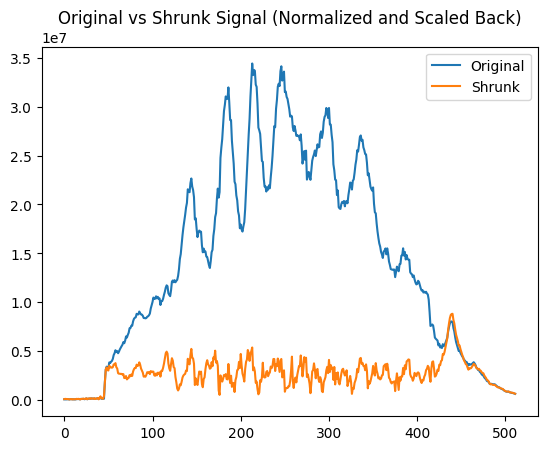

Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Normalized Test Segment Min/Max (Magnitude): 0.0002503729747058985 1.0
Shrunk Signal Min/Max (Magnitude): 5960.38302553444 8789859.660885392
YSig_normalized min/max (Magnitude): 0.00017303066802087572 0.2551707302059458


In [ ]:
def mst_abs(Ssig, coarsest=3, finestlev=4):  # Further reduce finestlev to 4 to minimize boundary effects
    """
    Adaptive-Bayesian Shrinkage for one segment of complex IQ data.
    Ssig: Input complex segment (normalized to reasonable range)
    """
    # Separate real and imaginary parts
    real_part = Ssig.real
    imag_part = Ssig.imag
    
    # Forward Wavelet Transform for real and imaginary parts
    wavelet = 'db8'  # Keep Daubechies 8 for better signal representation
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    
    # Flatten coefficients for real and imaginary parts
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)  # Reuse coeff_slices
    
    # Print initial coefficient stats
    print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
    print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())
    
    # Compute prior parameters (combine real and imaginary for statistics)
    # Use magnitude for robustness
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = max(abs(Q1 - Q3) / 1.5, 1e-2)  # Increase minimum Pseudos to 1e-2 for stability
    mu = min(1 / Pseudos**2 if Pseudos != 0 else 1e-1, 5.0)  # Reduce mu to 5.0 to prevent underflow
    
    # Scale of spread (τ) based on input signal magnitude
    sigma_d2 = np.var(np.abs(Ssig))
    tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.5)  # Increase tau to 0.5 for stability
    
    print("mu:", mu)
    print("tau:", tau)
    print("Pseudos:", Pseudos)
    print("sigma_d2:", sigma_d2)
    
    # Iterative shrinkage across levels (for both real and imaginary)
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        epsilon = min(1 - (1 / (i - coarsest + 1)**1.0), 0.3)  # Keep epsilon cap at 0.3 for more shrinkage
        
        # Real part
        d_real = datawd_real[2**i:2**(i+1)] if i < finestlev else datawd_real[2**i:]
        if len(d_real) == 0:
            continue
        
        # Imaginary part
        d_imag = datawd_imag[2**i:2**(i+1)] if i < finestlev else datawd_imag[2**i:]
        
        # Compute densities and shrinkage (using magnitude for stability)
        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
        
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        print(f"Level {i} - de min/max:", de.min(), de.max())
        
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - m min/max:", m.min(), m.max())
        
        m_star = epsilon * de + (1 - epsilon) * m
        print(f"Level {i} - m_star min/max:", m_star.min(), m_star.max())
        
        # Bayes rule shrinkage (apply to real and imaginary proportionally, with clipping)
        delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + 
                     tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))) / mu
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag before division min/max:", delta_mag.min(), delta_mag.max())
        
        delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10)  # Add small epsilon
        delta_mag = np.clip(delta_mag, 0, 0.3)  # Limit delta_mag to 0.3 to prevent over-shrinkage
        print(f"Level {i} - delta_mag min/max:", delta_mag.min(), delta_mag.max())
        
        delta_star = ((1 - epsilon) * m * delta_mag) / (m_star + 1e-10)  # Add small epsilon
        delta_star = np.clip(delta_star, 0, 0.3)  # Limit delta_star to 0.3 for controlled shrinkage
        print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())
        
        # Update real and imaginary parts (scale by original magnitude direction)
        if len(d_real) > 0:
            direction = d_real + 1j * d_imag
            direction_mag = np.abs(direction)
            direction_normalized = direction / (direction_mag + 1e-10)  # Avoid division by zero
            delta_real = delta_star * direction_normalized.real
            delta_imag = delta_star * direction_normalized.imag
            
            if i < finestlev:
                datawd_real[2**i:2**(i+1)] = delta_real
                datawd_imag[2**i:2**(i+1)] = delta_imag
            else:
                datawd_real[2**i:] = delta_real
                datawd_imag[2**i:] = delta_imag
    
    # Inverse Wavelet Transform for real and imaginary parts
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    YSig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    YSig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    
    # Combine real and imaginary parts
    YSig = YSig_real + 1j * YSig_imag
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment with normalization
test_segment = segmented_data[0, 0, :]
max_magnitude = np.abs(test_segment).max()
test_segment_normalized = test_segment / (max_magnitude + 1e-10)  # Normalize to max magnitude of 1

YSig_normalized = mst_abs(test_segment_normalized)
YSig_scaled = YSig_normalized * max_magnitude  # Scale back to original magnitude range

plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig_scaled), label='Shrunk')
plt.legend()
plt.title('Original vs Shrunk Signal (Normalized and Scaled Back)')
plt.show()

# Debug prints for input and output
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Normalized Test Segment Min/Max (Magnitude):", np.abs(test_segment_normalized).min(), np.abs(test_segment_normalized).max())
print("Shrunk Signal Min/Max (Magnitude):", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())
print("YSig_normalized min/max (Magnitude):", np.abs(YSig_normalized).min(), np.abs(YSig_normalized).max())